In [1]:
import numpy as np
from matplotlib import pyplot as plt
import keras.backend as K
from keras import Input, Model
from keras.layers import Lambda, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam
from matplotlib import pyplot as plt

import sys
sys.path.append("..")
from generative_models import utils

/home/luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class PredictiveModel:
    def __init__(self, timesteps):
        self._timesteps = timesteps
        
    def build_model(self):
        optimizer = Adam(clipnorm=1.0)
        model_inputs = Input((self._timesteps,))
        
        prediction = Lambda(lambda x : K.expand_dims(x))(model_inputs)
        prediction = LSTM(8, return_sequences=True)(prediction)
        prediction = TimeDistributed(Dense(1, activation='tanh'))(prediction)
        prediction = Lambda(lambda x : K.squeeze(x, -1))(prediction)
        
        self._model = Model(model_inputs, prediction)
        self._model.compile(loss='mse', optimizer=optimizer)
        return self._model
    
    def train(self, epochs, x_train, y_train, x_val, y_val):
        self._model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

In [3]:
def split_data(data, split, targets):
    split_index = int(data.shape[0]*split)
    train = data[split_index:, :]
    test = data[:split_index, :]
    
    x_train = train[:, :-targets]
    y_train = train[:, -targets:]
    x_test = test[:, :-targets]
    y_test = test[:, -targets:]
    
    return (x_train, y_train), (x_test, y_test)

In [4]:
transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
generated_transactions_filepath = '../generative_models/wgan_gp/outputs/final/2018-06-07_17-28-47/generated_datasets/last.npy'

elements = 10000
timesteps = 90

train_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]
x_train = train_data[:,:-1]
y_train = train_data[:, 1:]

val_data = utils.load_splitted_dataset(generated_transactions_filepath, timesteps)[:elements]
x_val = val_data[:, :-1]
y_val = val_data[:, 1:]

epochs = 10

In [6]:
predictive_model = PredictiveModel(timesteps-1)
model = predictive_model.build_model()
predictive_model.train(epochs, x_train, y_train, x_val, y_val)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0088 - val_loss: 0.0334
Epoch 2/10
10000/10000 [==============================] - 66s 7ms/step - loss: 0.0066 - val_loss: 0.0330
Epoch 3/10
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0065 - val_loss: 0.0327
Epoch 4/10
10000/10000 [==============================] - 64s 6ms/step - loss: 0.0064 - val_loss: 0.0325
Epoch 5/10
10000/10000 [==============================] - 70s 7ms/step - loss: 0.0063 - val_loss: 0.0323
Epoch 6/10
10000/10000 [==============================] - 73s 7ms/step - loss: 0.0063 - val_loss: 0.0322
Epoch 7/10
10000/10000 [==============================] - 82s 8ms/step - loss: 0.0063 - val_loss: 0.0322
Epoch 8/10
10000/10000 [==============================] - 67s 7ms/step - loss: 0.0063 - val_loss: 0.0322
Epoch 9/10
10000/10000 [==============================] - 66s 7ms/step - loss: 0.0063 - val_loss: 0.0322
Epoch

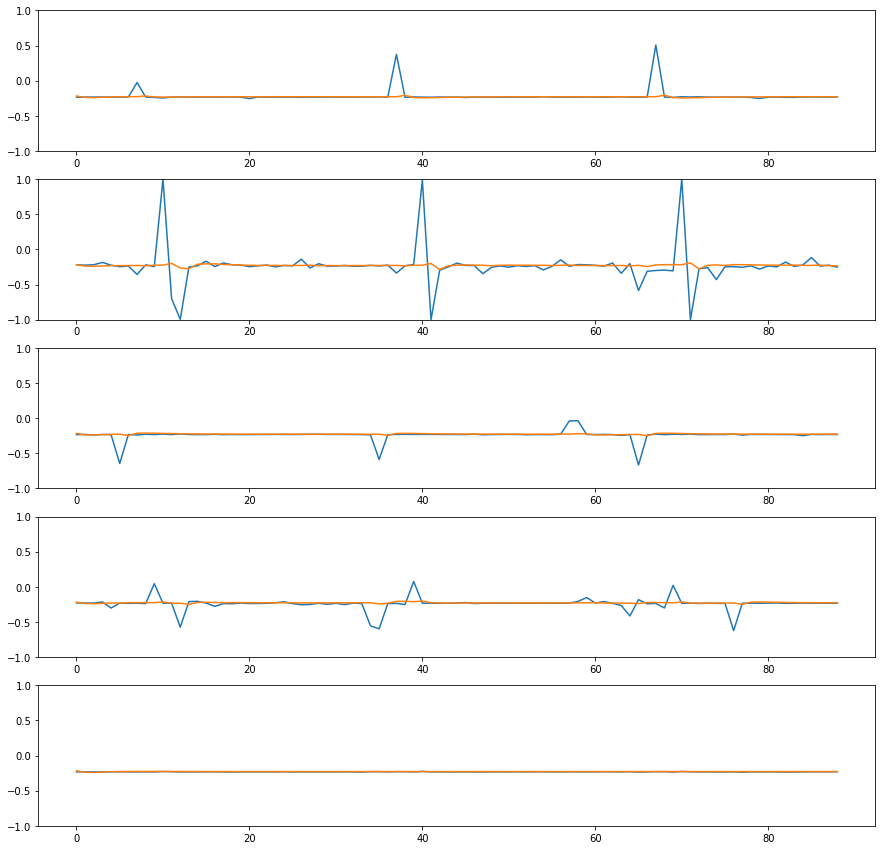

In [7]:
samples = 5
indexes = np.random.choice(10000, samples)

plt.subplots(samples, 1, figsize=(15, 3*samples))
for i, index in enumerate(indexes):
    plt.subplot(samples, 1, i+1)
    plt.plot(y_val[index])
    plt.plot(model.predict(x_val[index:index+1]).T)
    plt.ylim(-1, 1)
plt.show()